**# Script Para Entrenamineto del Modelo Personalizado**

### Este cuaderno de google-colab, muestra una guia de entrenamiento de modelos personalizados para la detccion de objetos utilizando el framework TensorFlow 

# Paso 1: Recolección de imagenes y etiquetado con Labelimg

Para la Recoleccion de imagenes, se estima que sean entre 800 y 1000 imaganes para que el entrenamiento sea eficiente, luego etiquetar cada una de estas imagenes con el programa (labelimg), este procedimiento se eplica en la guia paso a paso.

# Paso 2: Instalacion de las Dependencias de Deteccion de Objetos de TensorFlow

In [ ]:
# Clonamos el repositorio de los modelos de tensorflow desde GitHub !!!
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Se copian los archivos de instalacion a la carpeta de los mo
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
# Modificar setup.py si desea instalar otra version de TensorFlow del repositorio
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Establecer la Ruta
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [ ]:
# Instalar API de deteccion de objetos
!pip install /content/models/research/

# Instalar TensorFlow Version 2.8.0
!pip install tensorflow==2.8.0

In [ ]:
# Ejecuta un Archivo de prueba, para verificar que todo funcione correctamente 
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

# Paso 3: Cargar Conjunto de Datos (Imagenes y Etiquetado)

Para este paso se cargara el conjunto de datos para el entrenamiento con TensorFlow, Primero se debe comprimir todas las imágenes de entrenamiento y archivos XML en una sola carpeta llamada "imágenes.zip". Los archivos deben estar directamente dentro de la carpeta zip (sin carpetas añidadas) como se muestra a continuación:

```
images.zip
-- img1.jpg
-- img1.xml
-- img2.jpg
-- img2.xml
...
```

### 3.1 Subir Imagenes 
Para subir las imagenes hay dos opciones 

**Opción 1. Sube através de Google Colab**

Haciendo clic en el icono "Archivos" en el lado izquierdo del navegador y luego en el icono "Cargar en el almacenamiento". Seleccione la carpeta zip desde su pc para cargarla.

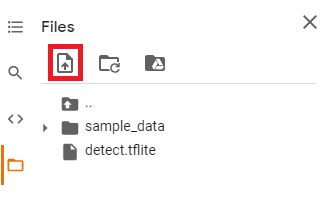

**Opción 2. Copiar desde Google Drive**

Montar la unidad en esta sesión de Colab y copiarlas en el sistema de archivos. Esta opción funciona bien si desea cargar las imágenes de antemano para que no tenga que esperar a que se carguen cada vez que reinicie este Colab.

Primero, cargue el archivo "images.zip" en su Google Drive y tome nota de la carpeta en la que las cargó. Reempláce "/content/gdrive/MyDrive/path/to/images.zip" por la ruta a su archivo zip. (Por ejemplo, si subí el archivo zip a la carpeta llamada "entrenamiento", por lo que lo usaría "/content/gdrive/MyDrive/entrenamiento/images.zip" para la ruta). Luego, ejecute el siguiente bloque de código para montar su Google Drive a Colab.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/images.zip /content

### 3.2 Dividir las Imagenes en tres carpetas: Entrenamiento, Validacion, y Prueba

Ya sea que haya utilizado la opción 1 o 2 debería poder hacer clic en el icono de archivos a la izquierda y ver "images.zip". Ahora que el conjunto de datos está cargado, vamos a descomprimirlo y crear tres carpetas para contener las imágenes, entrenamiento, validacion y prueba corriendo el siguiente codigo. 

In [ ]:
!mkdir /content/images
!unzip -q images.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test


Se dividen las imágenes en conjuntos de entrenamiento, validación y prueba.

Este script movera aleatoriamente el 80 % de las imágenes a la carpeta "entrenamiento", el 10 % a la carpeta "validación" y el ultimo 10 % a la carpeta "prueba".


In [ ]:
!wget https://raw.githubusercontent.com/BIOSDrex/TensorFlowLite/master/scripts/train_val_test_split.py
!python train_val_test_split.py

### 3.3 Creación de los archivos Labelmap y TFRecords 

Se necesita crear un mapa de etiquetas (labelmap) y convertir las imágenes a un formato de archivo de datos llamado TFRecords, que TensorFlow usa para el entrenamiento. Antes de ejecutarlos, se necesita definir un mapa de etiquetas para las clases.

La siguiente sección de código creará un archivo "labelmap.txt" que contiene una lista de las clases personalizadas. solo tiene que Reemplazar el texto class1, class2, class3 con sus propias clases (ejemplo, persona, perro, gato etc), luego ejecuta el codigo.

In [ ]:
### creacion del archivo "labelmap.txt con las clases" 
%%bash
cat <<EOF >> /content/labelmap.txt
class1
class2
class3
EOF

Descargue y ejecute los scripts de conversión de datos del repositorio de GitHub, solo haciendo clic en reproducir en las siguientes tres secciones de código Crearán archivos TFRecord para los conjuntos de datos de entrenamiento y validación, así como un archivo 'labelmap.pbtxt' que contiene el mapa de etiquetas en un formato diferente.

In [ ]:
# conversion
! wget https://raw.githubusercontent.com/BIOSDrex/TensorFlowLite/master/scripts/create_csv.py
! wget https://raw.githubusercontent.com/BIOSDrex/TensorFlowLite/master/scripts/create_tfrecord.py

In [ ]:
# Creación de los archivos CSV y TFRecords 
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

In [ ]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# Paso 4: Configuración del Entrenamiento

En esta sección, se configurara el modelo y el entrenamiento. si desea correr otro modelo diferente a los que estan es el scripts solo entre a este link y escoja el modelo que quiere usar [TensorFlow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). . Cada modelo también viene con un archivo de configuración que apunta a las ubicaciones de los archivos, establece parámetros de entrenamiento (como la tasa de aprendizaje y el número total de pasos de entrenamiento) y más. 

La primera sección del código enumera algunos modelos disponibles en TF2 

Configure la variable "chosen_model" para que coincida con el nombre del modelo con el que le gustaría entrenar. Actualmente está configurado para usar el popular modelo "ssd-mobilenet-v2" si no desea cambiar otro modelo solo ejecute el scrpts sin modificar nada. 

In [ ]:
# Elegir el Modelo
chosen_model = 'ssd-mobilenet-v2'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

Descargue el archivo del modelo preentrenado y el archivo de configuración, ejecutando la siguiente sección de codigo.

In [ ]:
# Creacion de la carpeta "mymodel" para los pesos previamente entrenados
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Descargar los pesos del modelo Pre-entrenado 
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Descargar el archivo de configuración para el entrenamiento 
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

despues de descargar el modelo y archivo de configuración, se modifica el archivo de configuración con algunos parámetros de entrenamiento. Las siguientes variables se utilizan para controlar los pasos de entrenamiento:

num_steps: la cantidad total de pasos que se usarán para entrenar el modelo. Un buen número para empezar es 20.000 pasos. Cuantos más pasos, más tiempo llevará el entrenamiento.

batch_size: la cantidad de imágenes que se usarán por paso de entrenamiento. Con las GPU utilizadas en las instancias de Colab, 16 es un buen número para los modelos SSD y 4 es bueno para los modelos EfficientDet.

In [ ]:
# Parametros del Entrenamiento
num_steps = 20000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 16

In [ ]:
# Obtener el numero de clases
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)

A continuación, se reescribe el archivo de configuración para usar los parámetros de entrenamiento modificados. La siguiente sección de código los reemplazará automáticamente y lo guardará como un archivo "pipeline_file.config" personalizado.

In [ ]:
# creacion del archivo de configuración personalizado
import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
    
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)
      
      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)
    
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


Finalmente, configuramos las ubicaciones del archivo y el directorio de salida del modelo como variables para cuando llamemos al comando de entrenamiento.

In [ ]:
# Ruta al archivo de configuración personalizado
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'

# Paso 5: Entrenamiento del modelo de deteccion personalizado.

Para entrenar nuestro modelo de detección de objetos, Antes de comenzar a entrenar, se carga una sesión de TensorBoard para monitorear el progreso del entrenamiento. Ejecute la siguiente sección de código y aparecerá una sesión de TensorBoard en el navegador. Todavía no mostrará nada, porque no se ha comenzado a entrenar. Una vez que comience el entrenamiento, regrese y haga clic en el botón Actualizar para ver la pérdida general del modelo.

In [ ]:
# Visualizar graficas con TensorBoard
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

El entrenamiento del modelo se realiza mediante el siguiente script de la API de detección de objetos de TF. el tiempo de entrenamiento tomará de 1 a 2 horas, según el modelo, el tamaño del lote y la cantidad de pasos.

In [ ]:
# Correr Entrenamiento
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1


Si desea detener el entrenamiento antes de tiempo cuando ya la perdida sea bastante baja, haga clic con el botón derecho en el bloque de código y seleccione "Interrumpir ejecución". De lo contrario, el entrenamiento se detendrá cuando termine el numero de pasos asignados.

# Paso 6: Convertir el Modelo a TensorFlow Lite

Luego de termine el entrenamineto, necesitamos exportar el gráfico del modelo (un archivo que contiene información sobre la arquitectura y los pesos) a un formato compatible con TensorFlow Lite.

In [ ]:
# conversion del modelo
!mkdir /content/custom_model_lite
output_directory = '/content/custom_model_lite'

last_model_path = '/content/training'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


A continuación, se toma el gráfico exportado y usaremos el módulo 'TFLiteConverter' para convertirlo al formato '.tflite' 

In [ ]:
# convierte a .tflite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

# Paso 7: Prueba del modelo personalizado y Calculo de la precisión media(mAP).

Despues de convertir el modelo al formato TFLite. se toma la carpeta con las imagenes de prueba y se corre el siguiente script para ver como se comporta el modelo

### 7.1 Inferencia con las imagenes de prueba

El siguiente código define una función para ejecutar la inferencia en imágenes de prueba. Carga las imágenes, carga el modelo y el mapa de etiquetas, ejecuta el modelo en cada imagen y muestra el resultado. Opcionalmente, también guarda los resultados de detección como archivos de texto para que podamos usarlos para calcular la puntuación de mAP del modelo.

In [ ]:
# Script de prueba

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5


  images_to_test = random.sample(images, num_test_images)


  for image_path in images_to_test:

      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape 
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()


      boxes = interpreter.get_tensor(output_details[1]['index'])[0] 
      classes = interpreter.get_tensor(output_details[3]['index'])[0] 
      scores = interpreter.get_tensor(output_details[0]['index'])[0] 

      detections = []

      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):


              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))
              
              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # label
              object_name = labels[int(classes[i])] 
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) 
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) 
              label_ymin = max(ymin, labelSize[1] + 10) 
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) 
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) 

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])

      
      if txt_only == False:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()
      

      elif txt_only == True:

        
        image_fn = os.path.basename(image_path)      
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

El siguiente bloque establece las rutas a las imágenes y modelos de prueba y luego ejecuta la función de inferencia.

In [ ]:
# variables y carpetas del modelo
PATH_TO_IMAGES='/content/images/test'   # ruta a la carpeta imagenes de prueba
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # ruta a la carpeta donde se encuentra el modelo.tflite
PATH_TO_LABELS='/content/labelmap.txt'   # ruta a la carpeta donde se encuentra el archivo.txt
min_conf_threshold=0.5   # umbral de confianza
images_to_test = 10  # numero de imagenes de prueba

# correr la funcion de inferencia
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

### 7.2 Calcular (mAP)

precisión media (mAP). Cuanto mayor sea la puntuación de mAP, mejor será su modelo para detectar objetos

In [ ]:
%%bash
git clone https://github.com/Cartucho/mAP /content/mAP
cd /content/mAP
rm input/detection-results/* 
rm input/ground-truth/* 
rm input/images-optional/* 
wget https://raw.githubusercontent.com/BIOSDrex/TensorFlowLite/master/scripts/calculate_map_cartucho.py

A continuación, copiaremos las imágenes y los datos de anotación de la carpeta de prueba. Estos se utilizarán como los "datos de verdad" con los que se compararán los resultados de detección del modelo.

In [ ]:
!cp /content/images/test/* /content/mAP/input/images-optional # Copiar imagenes y archivos xml
!mv /content/mAP/input/images-optional/*.xml /content/mAP/input/ground-truth/  # Mover archivos xml

In [ ]:
!python /content/mAP/scripts/extra/convert_gt_xml.py

Configurado los datos, los resultados de la detección se compararán con los datos de verdad para calcular la precisión del modelo en mAP. Solo toca ejecutar el siguiente bloque de código.

In [ ]:
# Configurar variables para ejecutar la inferencia
PATH_TO_IMAGES='/content/images/test'   # ruta de la carpeta de las imagenes de prueba
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # ruta de la carpeta donde esta el modelo.tflite
PATH_TO_LABELS='/content/labelmap.txt'   # ruta de la carpeta donde esta el archivo.txt
PATH_TO_RESULTS='/content/mAP/input/detection-results' # carpeta para guardar los resultados de la deteccion
min_conf_threshold=0.1   # umbral de confianza


image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = min(500, len(image_list)) 


txt_only = True

# correr la inferencia
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Finalmente, ¡calculemos mAP! con el bloque de codigo siguiente

In [ ]:
%cd /content/mAP
!python calculate_map_cartucho.py --labels=/content/labelmap.txt

La puntuación que muestra al final es la puntuación mAP general de su modelo. Lo ideal es que esté por encima del 50% (0,50). Si no es así, para aumentar la precisión tocaria aumentar la cantidad de iamgenes.

# Paso 8: Descargar Modelo TensorFlow Lite

Ejecute los dos bloques de codigo siguientes para copiar los archivos labelmap en la carpeta del modelo, comprimirlos en una carpeta zip y descargarlos. La carpeta zip contiene los archivos de modelo y labelmap necesarios para ejecutarlo.

In [ ]:
# Move labelmap and pipeline config files into TFLite model folder and zip it up
!cp /content/labelmap.txt /content/custom_model_lite
!cp /content/labelmap.pbtxt /content/custom_model_lite
!cp /content/models/mymodel/pipeline_file.config /content/custom_model_lite

%cd /content
!zip -r custom_model_lite.zip custom_model_lite

In [ ]:
from google.colab import files

files.download('/content/custom_model_lite.zip')